In [461]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['figure.dpi'] = 500
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from matplotlib.patches import FancyArrowPatch
from astropy.visualization import SqrtStretch, LinearStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import pandas as pd
import re
from astropy.io import fits
import os
from scipy.ndimage import map_coordinates
from scipy.stats import binned_statistic
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

from matplotlib.lines import Line2D
os.chdir("/Users/ainsleylewis/Documents/Astronomy/IllustrisTNG Lens Modelling")

In [426]:
# Model Opening
model_path = 'Test/SIE+SHEAR'
model_ver = 'SIE_POS_SHEAR'
lens_name = f'"{model_path}"'

if 'POS+FLUX' in model_ver:
    constraint = 'pos_flux'
elif 'POS' in model_ver:
    constraint = 'pos'


# Load the data
with open(model_path + '/' + model_ver + '_optresult' + '.dat', 'r') as file:
    opt_result = file.readlines()

opt_result

['------------------------------------------\n',
 'optimize ndim=0\n',
 'run 1: 0 lens models calculated\n',
 'chi^2 = 0.000000e+00  [N_data(extend): 0]\n',
 ' extend     : 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' point no 1 : 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' lens prior : 0.000000e+00\n',
 ' map prior  : 0.000000e+00\n',
 '\n',
 'omega = 0.3000  lambda = 0.7000  weos = -1.0000  hubble = 0.7000\n',
 '\n',
 'lens   sie     0.2613  1.300000e+02  2.078000e+01  2.078000e+01  1.070000e-01  2.338000e+01  0.000000e+00  0.000000e+00 \n',
 'lens   pert    0.2613  1.000000e+00  2.078000e+01  2.078000e+01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 \n',
 'point  1.0000  2.078000e+01  2.078000e+01 \n',
 '------------------------------------------\n']

In [427]:
# Find the last line with 'optimize' in it
last_optimize_index = None
for idx in range(len(opt_result) - 1, -1, -1):
    if 'optimize' in opt_result[idx]:
        last_optimize_index = idx
        last_optimize_line = opt_result[idx]
        break
if last_optimize_index is None:
    raise ValueError("No line with 'optimize' found in the file.")

print(f"Last 'optimize' line found at index: {last_optimize_index}")

# Extract everything after the last 'optimize' line
opt_result = opt_result[last_optimize_index + 1:]

opt_result


Last 'optimize' line found at index: 1


['run 1: 0 lens models calculated\n',
 'chi^2 = 0.000000e+00  [N_data(extend): 0]\n',
 ' extend     : 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' point no 1 : 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' lens prior : 0.000000e+00\n',
 ' map prior  : 0.000000e+00\n',
 '\n',
 'omega = 0.3000  lambda = 0.7000  weos = -1.0000  hubble = 0.7000\n',
 '\n',
 'lens   sie     0.2613  1.300000e+02  2.078000e+01  2.078000e+01  1.070000e-01  2.338000e+01  0.000000e+00  0.000000e+00 \n',
 'lens   pert    0.2613  1.000000e+00  2.078000e+01  2.078000e+01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 \n',
 'point  1.0000  2.078000e+01  2.078000e+01 \n',
 '------------------------------------------\n']

In [428]:
# Count the number of lines that start with 'lens'
lens_count = sum(1 for line in opt_result if line.startswith('lens'))
print(f"Number of 'lens' lines: {lens_count}")

# Initialize a dictionary to hold the lens parameters
lens_params_dict = {}

# Extract the lens parameters
lens_params = []
for line in opt_result:
    if line.startswith('lens'):
        # Extract the line and split it into parts
        parts = re.split(r'\s+', line.strip())
        print(parts)
        # Extract the lens name and parameters
        lens_name = parts[1]
        params = [float(x) for x in parts[2:]]

        # Store the parameters in the dictionary
        lens_params_dict[lens_name] = params
        lens_params.append((lens_name, params))

# Remove the first lens parameter
if lens_params:
    for i in range(len(lens_params)):
        lens_name, params = lens_params[i]
        lens_params_dict[lens_name] = params[1:]


# Number of len profiles
num_lens_profiles = len(lens_params_dict)
print(f"Number of lens profiles: {num_lens_profiles}")
    
lens_params_dict

Number of 'lens' lines: 2
['lens', 'sie', '0.2613', '1.300000e+02', '2.078000e+01', '2.078000e+01', '1.070000e-01', '2.338000e+01', '0.000000e+00', '0.000000e+00']
['lens', 'pert', '0.2613', '1.000000e+00', '2.078000e+01', '2.078000e+01', '0.000000e+00', '0.000000e+00', '0.000000e+00', '0.000000e+00']
Number of lens profiles: 2


{'sie': [130.0, 20.78, 20.78, 0.107, 23.38, 0.0, 0.0],
 'pert': [1.0, 20.78, 20.78, 0.0, 0.0, 0.0, 0.0]}

In [429]:
# Initialize a dictionary to hold the lens parameters
set_point_dict = {}

# Extract the lens parameters
set_points = []
for line in opt_result:
    if line.startswith('point'):
        # Extract the line and split it into parts
        parts = re.split(r'\s+', line.strip())
        print(parts)

set_point_values = [float(x) for x in parts[1:]]

set_point_values

['point', '1.0000', '2.078000e+01', '2.078000e+01']


[1.0, 20.78, 20.78]

In [430]:
# Use generic column names: param1, param2, ...
df = pd.DataFrame()
rows = []
max_param_len = 0

for lens_name, params in lens_params_dict.items():
    row = {'Lens Name': lens_name}
    for i, val in enumerate(params):
        row[f'param{i+1}'] = val
    rows.append(row)
    if len(params) > max_param_len:
        max_param_len = len(params)

columns = ['Lens Name'] + [f'param{i+1}' for i in range(max_param_len)]
df = pd.DataFrame(rows, columns=columns)

df['Lens Name'] = df['Lens Name'].apply(lambda x: f'"{x}"')

df

,Lens Name,param1,param2,param3,param4,param5,param6,param7
0,"""sie""",130.0,20.78,20.78,0.107,23.38,0.0,0.0
1,"""pert""",1.0,20.78,20.78,0.000,0.00,0.0,0.0


In [431]:
with open(model_path + '/' + 'pos_point' + '.py', 'r') as file:
    py = file.readlines()

py

['#!/usr/bin/env python\n',
 'import glafic\n',
 '\n',
 "glafic.init(0.3, 0.7, -1.0, 0.7, 'Test/SIE+SHEAR/SIE_POS_SHEAR', 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n",
 '\n',
 "glafic.set_secondary('chi2_splane 1', verb = 0)\n",
 "glafic.set_secondary('chi2_checknimg 0', verb = 0)\n",
 "glafic.set_secondary('chi2_restart   -1', verb = 0)\n",
 "glafic.set_secondary('chi2_usemag    1', verb = 0)\n",
 "glafic.set_secondary('hvary          0', verb = 0)\n",
 "glafic.set_secondary('ran_seed -122000', verb = 0)\n",
 '\n',
 'glafic.startup_setnum(2, 0, 1)\n',
 "glafic.set_lens(1, 'sie', 0.261343256161012, 1.30e+02, 20.78, 20.78, 0.107, 23.38, 0.000000e+00, 0.0)\n",
 "glafic.set_lens(2, 'pert', 0.261343256161012, 1.0, 20.78, 20.78, 0.0, 0.0, 0.0, 0.0)\n",
 'glafic.set_point(1, 1.0, 20.78, 20.78)\n',
 '\n',
 'glafic.setopt_lens(1, 0, 0, 0, 0, 0, 0, 0, 0)\n',
 'glafic.setopt_lens(2, 0, 0, 0, 0, 0, 0, 0, 0)\n',
 'glafic.setopt_point(1, 0, 0, 0)\n',
 '\n',
 '# model_init needs to be done 

In [432]:
# Read the existing file contents
with open('Test/kappa.py', 'r') as f:
    lines = f.readlines()

i = 0
lens_name = model_path + '/' + df['Lens Name'][i].strip('"')
lens_name = f'"{lens_name}"'
print(lens_name)

# Modify lines
new_lines = []
for line in lines:
    if 'glafic.set_lens(' in line:
        print('Found glafic.set_lens')
        line = f"glafic.set_lens(1, {df['Lens Name'][i]}, 0.261343256161012, {df['param1'][i]}, {df['param2'][i]}, {df['param3'][i]}, {df['param4'][i]}, {df['param5'][i]}, {df['param6'][i]}, {df['param7'][i]})\n"
    elif 'glafic.init(' in line:
        line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {lens_name}, 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n"
    elif 'glafic.set_point(' in line:
        print('Found glafic.set_point')
        if set_point_values is not None and len(set_point_values) == 3:
            line = f"glafic.set_point(1, 1.000, {set_point_values[1]}, {set_point_values[2]})\n"
        else:
            print("set_point_values is not set correctly.")
    new_lines.append(line)

# Write back once
with open('Test/kappa.py', 'w') as glafic_file:
    glafic_file.writelines(new_lines)

"Test/SIE+SHEAR/sie"
Found glafic.set_lens
Found glafic.set_point


In [433]:
%run Test/kappa.py

######## writing lens properties
 zs = 1.000000e+00 
 output file name = Test/SIE+SHEAR/sie_lens.fits 



In [434]:
# FITS File 
lens_name = lens_name.strip('"')
image = lens_name + '_lens' + '.fits'

hdu_list = fits.open(image)
hdu_list.info()

# Extract kappa 
gamma1_sie = hdu_list[0].data[4]
gamma1_sie = np.array(gamma1_sie)

gamma2_sie = hdu_list[0].data[5]
gamma2_sie = np.array(gamma2_sie)

Filename: Test/SIE+SHEAR/sie_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (156, 156, 8)   float32   


In [435]:
# Read the existing file contents
with open('Test/kappa.py', 'r') as f:
    lines = f.readlines()

i = 1
lens_name = model_path + '/' + df['Lens Name'][i].strip('"')
lens_name = f'"{lens_name}"'
print(lens_name)

# Modify lines
new_lines = []
for line in lines:
    if 'glafic.set_lens(' in line:
        print('Found glafic.set_lens')
        line = f"glafic.set_lens(1, {df['Lens Name'][i]}, 0.261343256161012, {df['param1'][i]}, {df['param2'][i]}, {df['param3'][i]}, {df['param4'][i]}, {df['param5'][i]}, {df['param6'][i]}, {df['param7'][i]})\n"
    elif 'glafic.init(' in line:
        line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {lens_name}, 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n"
    elif 'glafic.set_point(' in line:
        print('Found glafic.set_point')
        if set_point_values is not None and len(set_point_values) == 3:
            line = f"glafic.set_point(1, 1.000, {set_point_values[1]}, {set_point_values[2]})\n"
        else:
            print("set_point_values is not set correctly.")
    new_lines.append(line)

# Write back once
with open('Test/kappa.py', 'w') as glafic_file:
    glafic_file.writelines(new_lines)

"Test/SIE+SHEAR/pert"
Found glafic.set_lens
Found glafic.set_point


In [436]:
%run Test/kappa.py

######## writing lens properties
 zs = 1.000000e+00 
 output file name = Test/SIE+SHEAR/pert_lens.fits 



In [437]:
# FITS File 
lens_name = lens_name.strip('"')
image = lens_name + '_lens' + '.fits'

hdu_list = fits.open(image)
hdu_list.info()

# Extract kappa 
gamma1_pert = hdu_list[0].data[4]
gamma1_pert = np.array(gamma1_pert)

gamma2_pert = hdu_list[0].data[5]
gamma2_pert = np.array(gamma2_pert)

Filename: Test/SIE+SHEAR/pert_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (156, 156, 8)   float32   


In [438]:
lens_name = model_path
lens_name = lens_name + '/' + model_ver + '_macro'
lens_name = f'"{lens_name}"'
print(lens_name)

# Read original file
with open('Test/kappa_common.py', 'r') as f:
    py = f.readlines()

# Modify lines
new_lines = []
for line in py:
    if 'glafic.init(' in line:
        line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {lens_name}, 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n"
    elif 'glafic.set_lens(1' in line:
        print('Found glafic.set_lens')
        line = f"glafic.set_lens(1, {df['Lens Name'][0]}, 0.261343256161012, {df['param1'][0]}, {df['param2'][0]}, {df['param3'][0]}, {df['param4'][0]}, {df['param5'][0]}, {df['param6'][0]}, {df['param7'][0]})\n"
    elif 'glafic.set_lens(2' in line:
        line = f"glafic.set_lens(2, {df['Lens Name'][1]}, 0.261343256161012, {df['param1'][1]}, {df['param2'][1]}, {df['param3'][1]}, {df['param4'][1]}, {df['param5'][1]}, {df['param6'][1]}, {df['param7'][1]})\n"
    elif 'glafic.set_lens(3' in line:
        line = f"glafic.set_lens(3, {df['Lens Name'][2]}, 0.261343256161012, {df['param1'][2]}, {df['param2'][2]}, {df['param3'][2]}, {df['param4'][2]}, {df['param5'][2]}, {df['param6'][2]}, {df['param7'][2]})\n"
    elif 'glafic.set_lens(4' in line:
        line = f"glafic.set_lens(4, {df['Lens Name'][3]}, 0.261343256161012, {df['param1'][3]}, {df['param2'][3]}, {df['param3'][3]}, {df['param4'][3]}, {df['param5'][3]}, {df['param6'][3]}, {df['param7'][3]})\n"
    elif 'glafic.set_point(' in line:
        print('Found glafic.set_point')
        if set_point_values is not None and len(set_point_values) == 3:
            line = f"glafic.set_point(1, 1.000, {set_point_values[1]}, {set_point_values[2]})\n"
        else:
            print("set_point_values is not set correctly.")
    new_lines.append(line)

# Write once, after all edits
with open('Test/kappa_common.py', 'w') as f:
    f.writelines(new_lines)

"Test/SIE+SHEAR/SIE_POS_SHEAR_macro"
Found glafic.set_lens
Found glafic.set_point


In [439]:
%run Test/kappa_common.py

######## writing lens properties
 zs = 1.000000e+00 
 output file name = Test/SIE+SHEAR/SIE_POS_SHEAR_macro_lens.fits 



In [440]:
# FITS File 
lens_name = lens_name.strip('"')
image = lens_name + '_lens' + '.fits'
print(image)

hdu_list = fits.open(image)
hdu_list.info()

# Extract kappa 
gamma1_tot = hdu_list[0].data[4]
gamma1_tot = np.array(gamma1_tot)

gamma2_tot = hdu_list[0].data[5]
gamma2_tot = np.array(gamma2_tot)

Test/SIE+SHEAR/SIE_POS_SHEAR_macro_lens.fits
Filename: Test/SIE+SHEAR/SIE_POS_SHEAR_macro_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (156, 156, 8)   float32   


In [441]:
gamma_sie = np.sqrt(gamma1_sie**2 + gamma2_sie**2)
gamma_pert = np.sqrt(gamma1_pert**2 + gamma2_pert**2)
gamma_tot = np.sqrt(gamma1_tot**2 + gamma2_tot**2)

In [442]:
file_crit = model_path + '/' + model_ver + '_crit.dat'
print(file_crit)
crit_curve = pd.read_csv(file_crit, delim_whitespace=True, header=None)
crit_curve = (crit_curve - 20) / 0.01
crit_curve

Test/SIE+SHEAR/SIE_POS_SHEAR_crit.dat


,0,1,2,3,4,5,6,7
0,78.5,43.0,78.941,75.778,78.0,43.5,78.933,76.278
1,78.5,43.0,78.941,75.778,79.5,43.0,78.954,75.750
2,79.5,43.0,78.954,75.750,80.5,43.0,78.968,75.694
3,80.5,43.0,78.968,75.694,81.5,43.0,78.987,75.610
4,81.5,43.0,78.987,75.610,82.5,43.0,79.012,75.498
...,...,...,...,...,...,...,...,...
443,78.0,78.0,46.798,88.030,78.0,78.0,46.099,85.879
444,78.0,78.0,46.099,85.879,78.0,78.0,45.556,83.702
445,78.0,78.0,45.556,83.702,78.0,78.0,45.169,81.508
446,78.0,78.0,45.169,81.508,78.0,78.0,44.937,79.307


In [443]:
obs_point = pd.read_csv('obs_point/obs_point_(POS+FLUX).dat', delim_whitespace=True, header=None, skiprows=1)
obs_point[0] = (obs_point[0] - 20) / 0.01
obs_point[1] = (obs_point[1] - 20) / 0.01
obs_point = obs_point[[0, 1]]
obs_point

,0,1
0,77.773,30.254
1,127.308,95.612
2,39.091,105.057
3,81.981,125.931


In [444]:
pred_point = pd.read_csv(model_path + '/' + model_ver + '_point.dat', delim_whitespace=True, header=None, skiprows=1)
pred_point[0] = (pred_point[0] - 20) / 0.01
pred_point[1] = (pred_point[1] - 20) / 0.01
pred_point = pred_point[[0, 1]]
pred_point

,0,1
0,90.93,48.10
1,46.95,64.57
2,109.05,91.43
3,65.07,107.90


In [462]:
# Row Switching

dist_matrix = cdist(obs_point.to_numpy(), pred_point.to_numpy(), 'euclidean')

obs_indices, pred_indices_optimal = linear_sum_assignment(dist_matrix)

print("\nOptimal index mapping for pred_point:", pred_indices_optimal)

pred_point_sorted = pred_point.iloc[pred_indices_optimal].reset_index(drop=True)


Optimal index mapping for pred_point: [0 2 1 3]


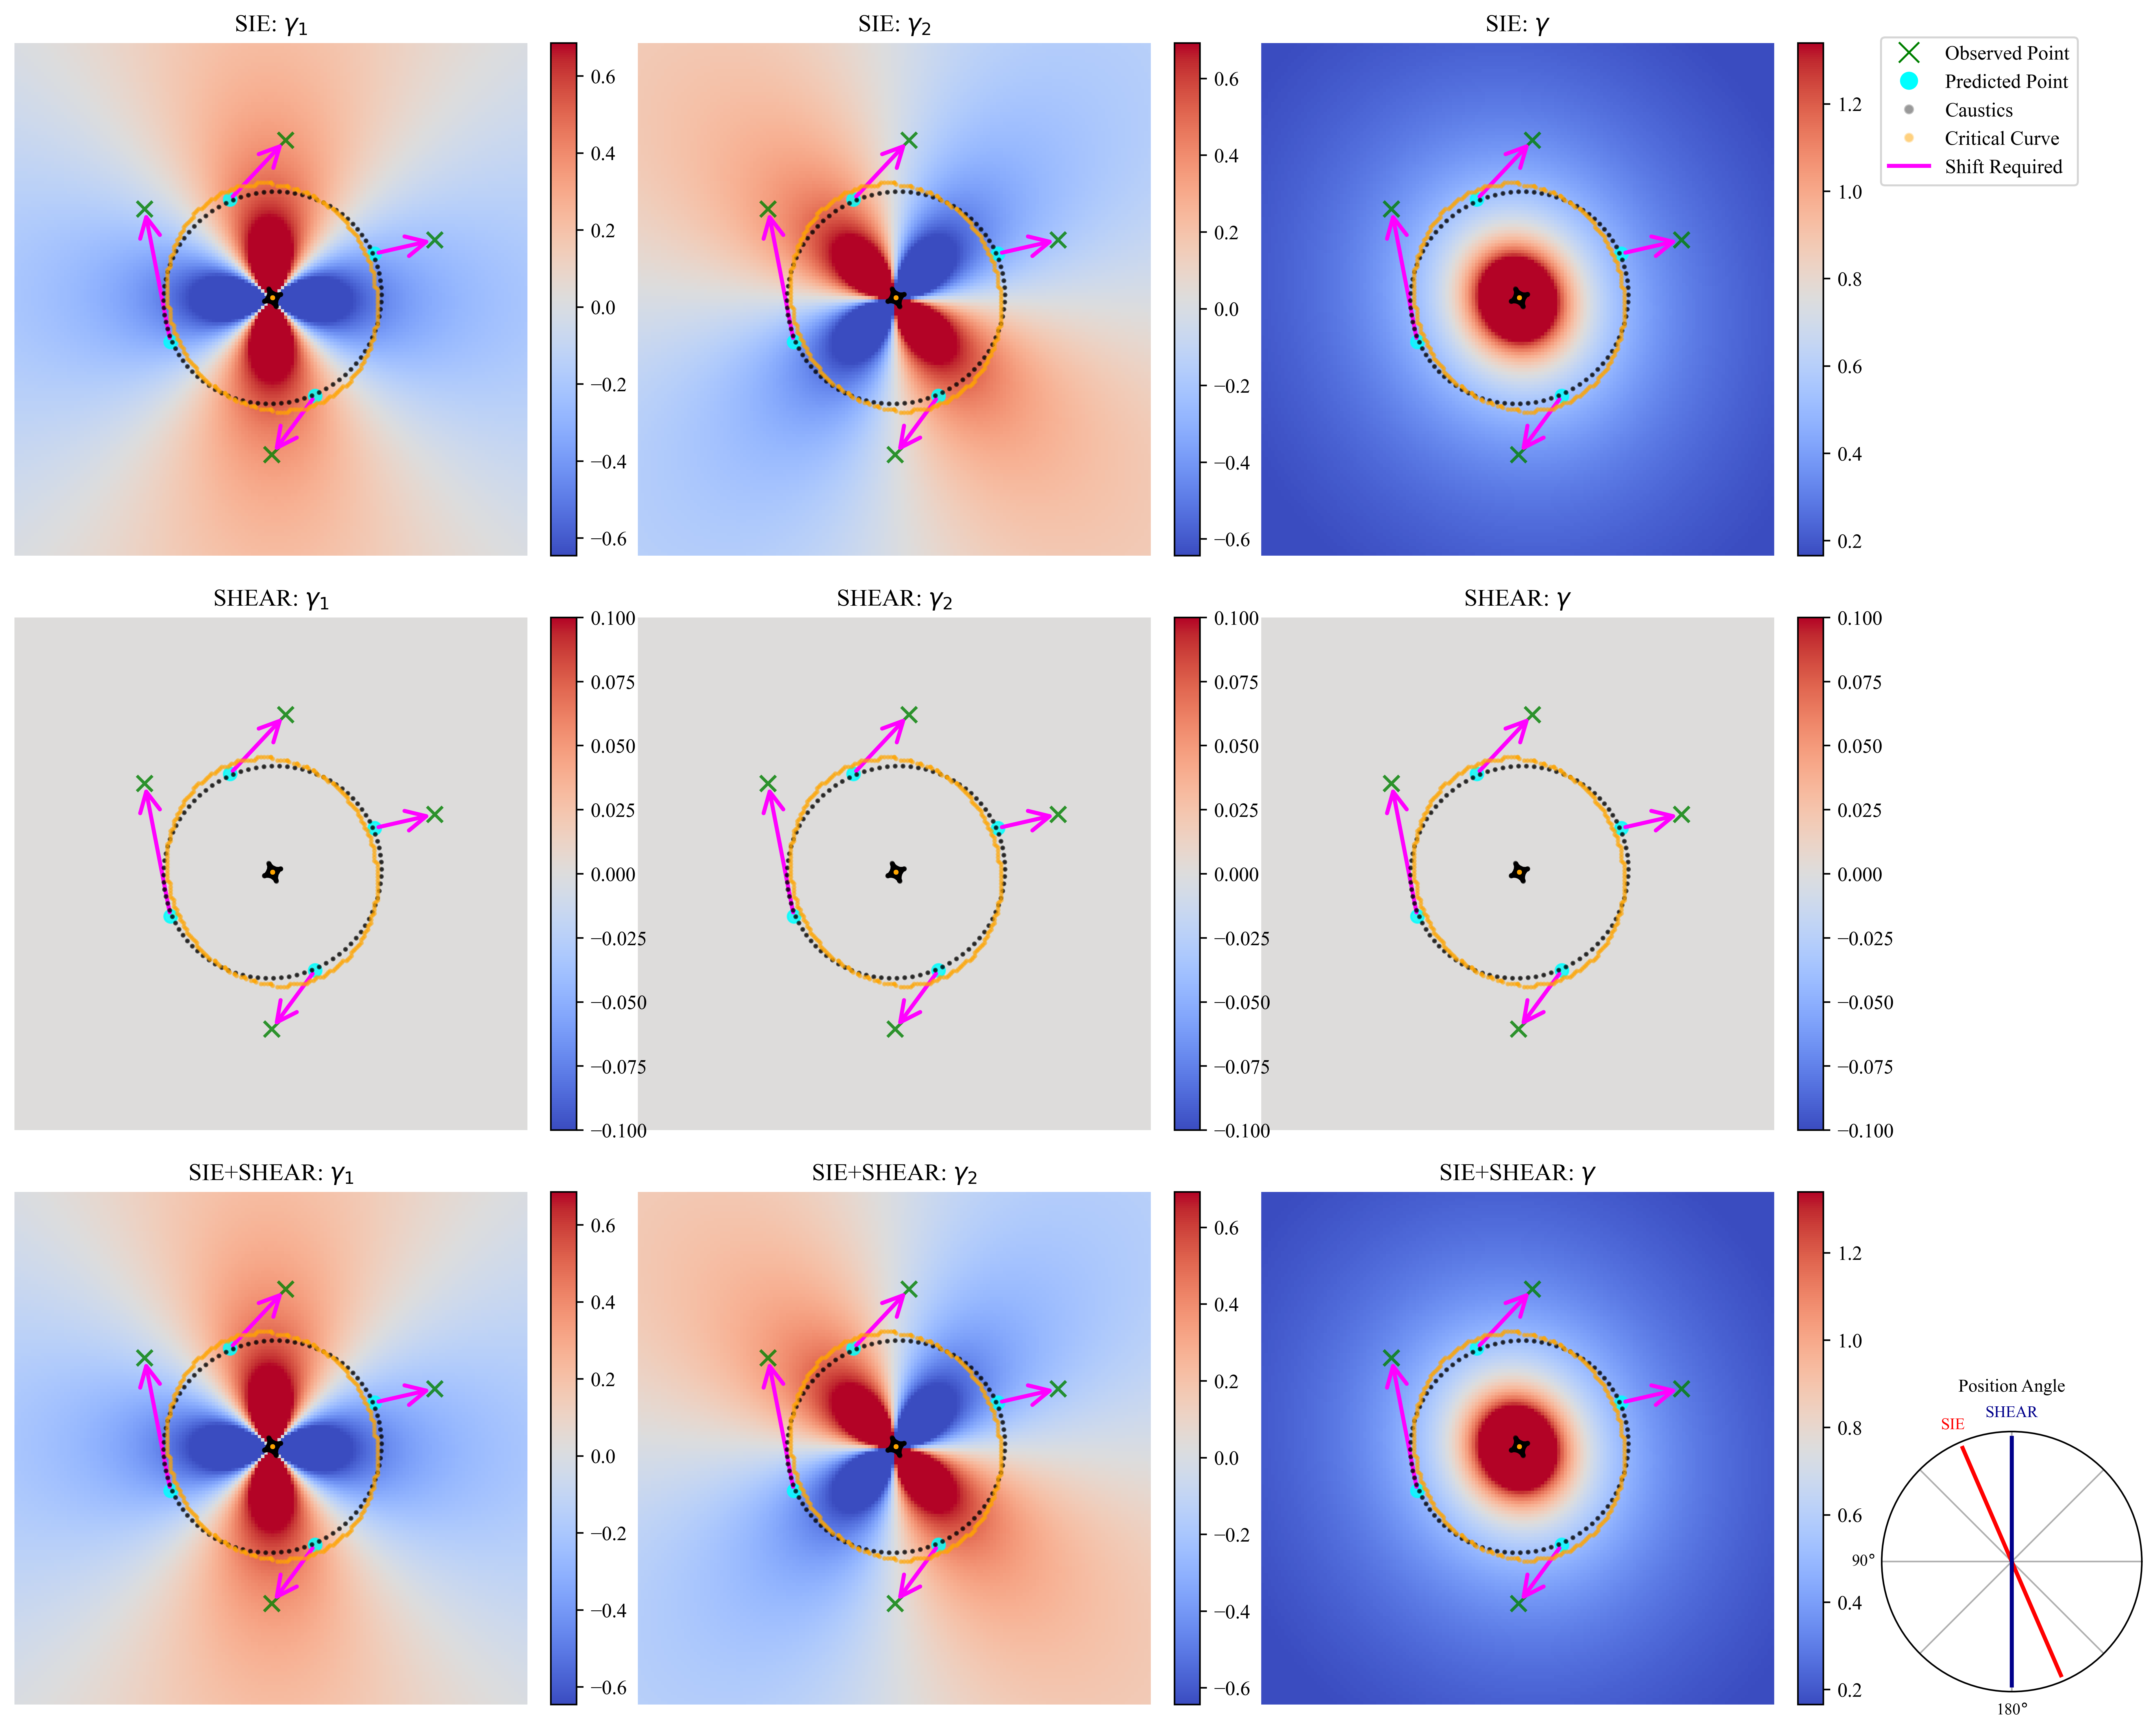

In [ ]:
gamma_arrays = [
    gamma1_sie, gamma2_sie, gamma_sie,
    gamma1_pert, gamma2_pert, gamma_pert,
    gamma1_tot, gamma2_tot, gamma_tot
]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
titles = [
    'SIE: $\gamma_1$', 'SIE: $\gamma_2$', 'SIE: $\gamma$',
    'SHEAR: $\gamma_1$', 'SHEAR: $\gamma_2$', 'SHEAR: $\gamma$',
    'SIE+SHEAR: $\gamma_1$', 'SIE+SHEAR: $\gamma_2$', 'SIE+SHEAR: $\gamma$'
]

for i, ax in enumerate(axes.flat):
    vmax, vmin = np.percentile(gamma_arrays[i], [98, 2])
    im = ax.imshow(gamma_arrays[i], origin='lower', cmap='coolwarm', vmax=vmax, vmin=vmin)

    # Plot all 4 observed and predicted points individually
    for j in range(len(obs_point)):  # len = 4 assumed
        x_obs, y_obs = obs_point.iloc[j, 0], obs_point.iloc[j, 1]
        x_pred, y_pred = pred_point_sorted.iloc[j, 0], pred_point_sorted.iloc[j, 1]

        # Plot each point
        ax.scatter(x_obs, y_obs, color='green', s=60, alpha=0.8, marker='x')
        ax.scatter(x_pred, y_pred, color='cyan', s=40, alpha=0.8, marker='o')

        # Draw arrow
        arrow = FancyArrowPatch(
            posA=(x_pred, y_pred),
            posB=(x_obs, y_obs),
            arrowstyle='->',
            color='magenta',
            linewidth=2,
            mutation_scale=25,
            alpha=1
        )
        ax.add_patch(arrow)
        # arrow.set_linestyle('dotted')

    # Plot critical curves
    ax.scatter(crit_curve[2], crit_curve[3], color='black', s=2, alpha=0.4)
    ax.scatter(crit_curve[4], crit_curve[5], color='orange', s=2, alpha=0.5)

    ax.set_title(titles[i])
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.axis('off')


legend_elements = [
    Line2D([0], [0], marker='x', color='w', label='Observed Point',
           markerfacecolor='green', markeredgecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Predicted Point',
           markerfacecolor='cyan', markeredgecolor='cyan', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Caustics',
           markerfacecolor='black', markersize=5, alpha=0.4),
    Line2D([0], [0], marker='o', color='w', label='Critical Curve',
           markerfacecolor='orange', markersize=5, alpha=0.5),
    Line2D([0], [0], color='magenta', lw=2, label='Shift Required',
           linestyle='-', alpha=1)
]

fig.legend(handles=legend_elements, loc='upper right', fontsize='medium',
           bbox_to_anchor=(0.98, 0.98), frameon=True, facecolor='white', framealpha=0.8)
plt.tight_layout(rect=[0, 0, 0.9, 1])

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Input angles in degrees
theta1_deg = df['param5'][0] + 90 # Adjusting for the convention
theta2_deg = df['param5'][1] + 90
theta180 = 180 + 90
theta180_rad = np.deg2rad(theta180)
theta90 = 90 + 90
theta90_rad = np.deg2rad(theta90)
angles = [np.deg2rad(theta1_deg), np.deg2rad(theta2_deg)]

# Create a polar axes manually in figure coordinates
ax_polar = fig.add_axes([0.87, 0.02, 0.15, 0.15], polar=True)  # [left, bottom, width, height]

labels = ['SIE', 'SHEAR']

colours = ['red', 'darkblue']

# Plot two radial lines
for angle, label in zip(angles, labels):
    ax_polar.plot([angle, angle], [0, 1], color=colours[labels.index(label)], linewidth=2)
    ax_polar.plot([angle + np.pi, angle + np.pi], [0, 1], color=colours[labels.index(label)], linewidth=2)
    ax_polar.text(angle, 1.2, label, fontsize=8, ha='center', va='center', color= colours[labels.index(label)])

ax_polar.text(theta180_rad, 1.2, '180$\degree$', fontsize=8, ha='center', va='center', color= 'black')
ax_polar.text(theta90_rad, 1.2, '90$\degree$', fontsize=8, ha='center', va='center', color= 'black')

# Make it look like a compass
ax_polar.set_rticks([])             # Hide radius ticks
ax_polar.set_yticklabels([])
ax_polar.set_xticklabels([])
ax_polar.grid(True)
ax_polar.spines['polar'].set_visible(True)

ax_polar.set_title("Position Angle", fontsize=9, pad=20)


plt.show()


In [361]:
# From profile center
i = 0
centers = [df['param2'][i], df['param3'][i]]
centers

[20.78, 20.78]

Using profile center (x, y) in pixel coordinates: (78.00, 78.00)


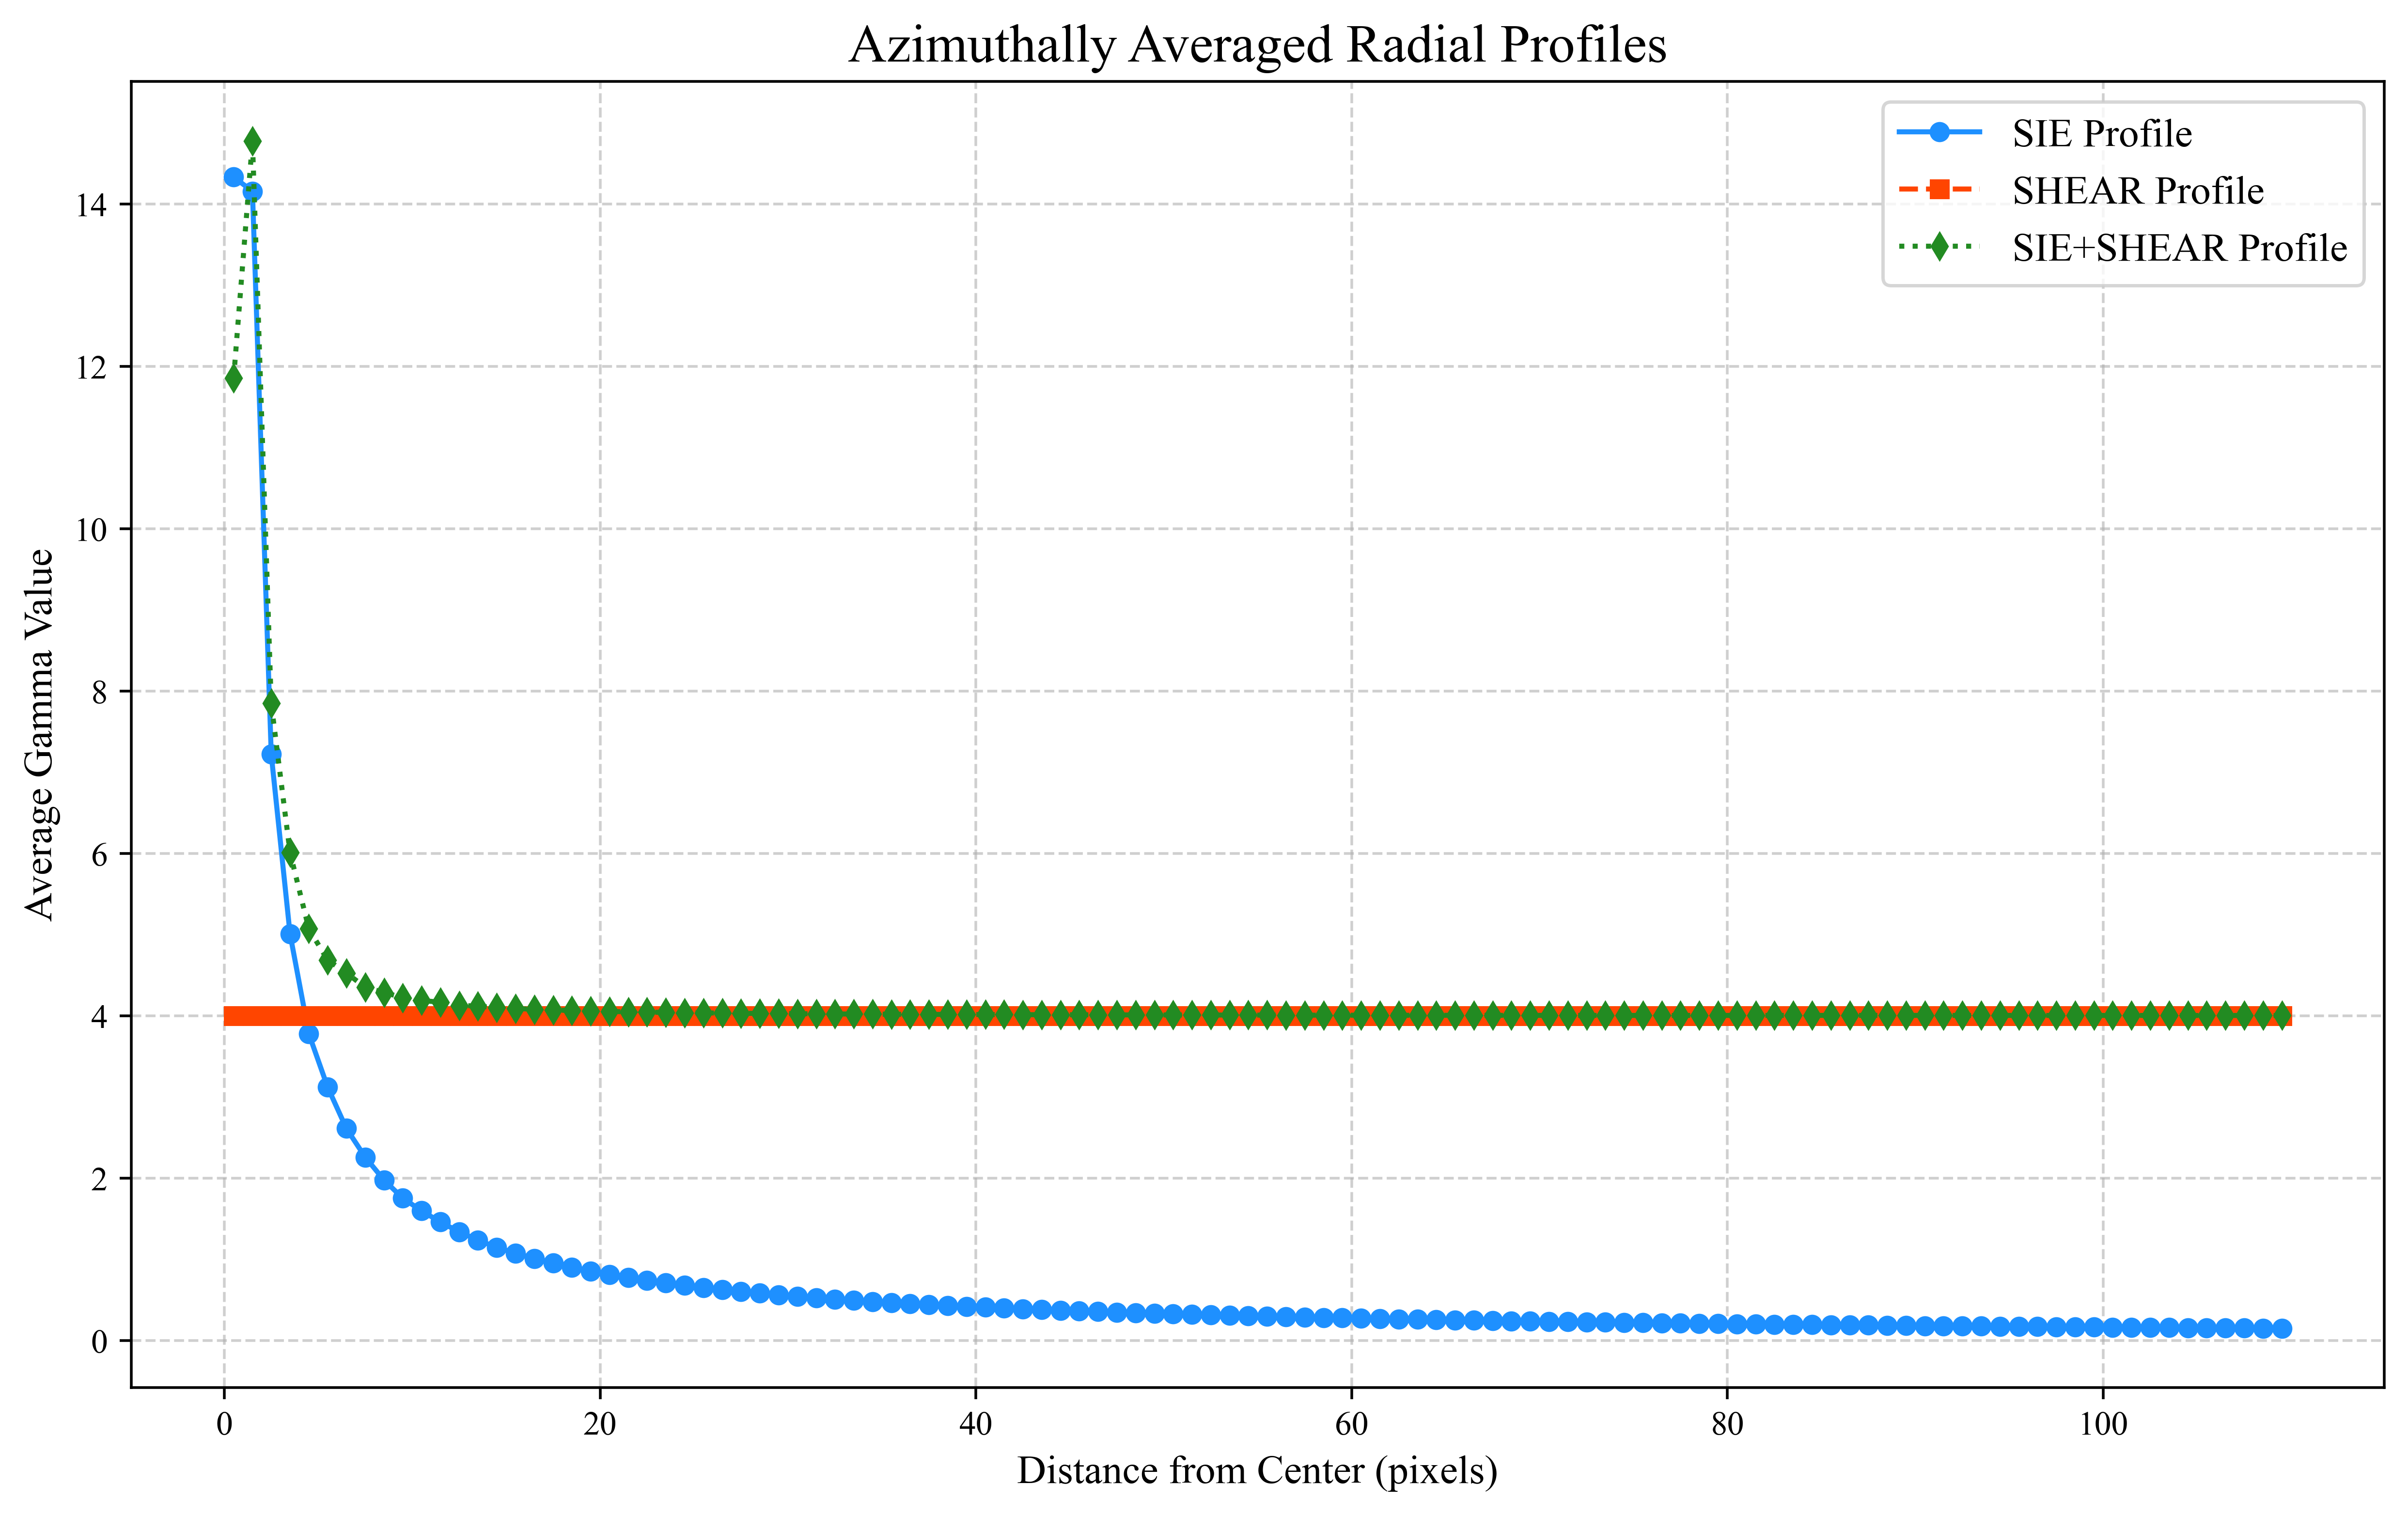

In [362]:
def calculate_radial_profile(image_data, center_coords):
    """
    Calculates the azimuthally averaged radial profile of an image.

    Args:
        image_data (np.ndarray): The 2D image array.
        center_coords (tuple): A tuple containing the (x, y) pixel coordinates of the center.

    Returns:
        tuple: A tuple containing (bin_centers, radial_profile).
    """
    center_x, center_y = center_coords
    
    # Create a grid of integer coordinates
    ny, nx = image_data.shape
    y, x = np.indices((ny, nx))

    # Create a grid of distances from the center
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)

    # Flatten the arrays to 1D for binning
    r_flat = r.flatten()
    image_flat = image_data.flatten()

    # Bin the data by radius using a 1-pixel width
    radial_bins = np.arange(0, r.max(), 1)

    # Use binned_statistic to calculate the mean value in each radial bin
    profile, bin_edges, _ = binned_statistic(
        r_flat, 
        image_flat, 
        statistic='mean', 
        bins=radial_bins
    )

    # Calculate the center of each bin for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return bin_centers, profile

# ======================================================================
# Main Script
# ======================================================================

# 1. Define and convert center coordinates ONCE
physical_x, physical_y = centers
center_x = (physical_x - 20) / 0.01  # Convert to pixel coordinates
center_y = (physical_y - 20) / 0.01  # Convert to pixel coordinates
print(f"Using profile center (x, y) in pixel coordinates: ({center_x:.2f}, {center_y:.2f})")

# 2. Calculate the profile for each dataset using our function
bin_centers_sie, profile_sie = calculate_radial_profile(gamma_sie, (center_x, center_y))
bin_centers_pert, profile_pert = calculate_radial_profile(gamma_pert, (center_x, center_y))
bin_centers_tot, profile_tot = calculate_radial_profile(gamma_tot, (center_x, center_y))


# 3. Plot both profiles on the same figure
plt.figure(figsize=(12, 7))
plt.title('Azimuthally Averaged Radial Profiles', fontsize=16)

# Plot the first profile
plt.plot(bin_centers_sie, profile_sie, 'o-', color='dodgerblue', label='SIE Profile', markersize=5)

# Plot the second profile on the SAME axes
plt.plot(bin_centers_pert, profile_pert, 's--', color='orangered', markersize=5, label='SHEAR Profile')

# Plot the third profile on the SAME axes
plt.plot(bin_centers_tot, profile_tot, 'd:', color='forestgreen', markersize=5, label='SIE+SHEAR Profile')

# Add labels and other plot elements
plt.xlabel('Distance from Center (pixels)', fontsize=12)
plt.ylabel('Average Gamma Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()


--- Calculating Line Profile at a Specific Angle ---
Center coordinates: (20.78, 20.78)


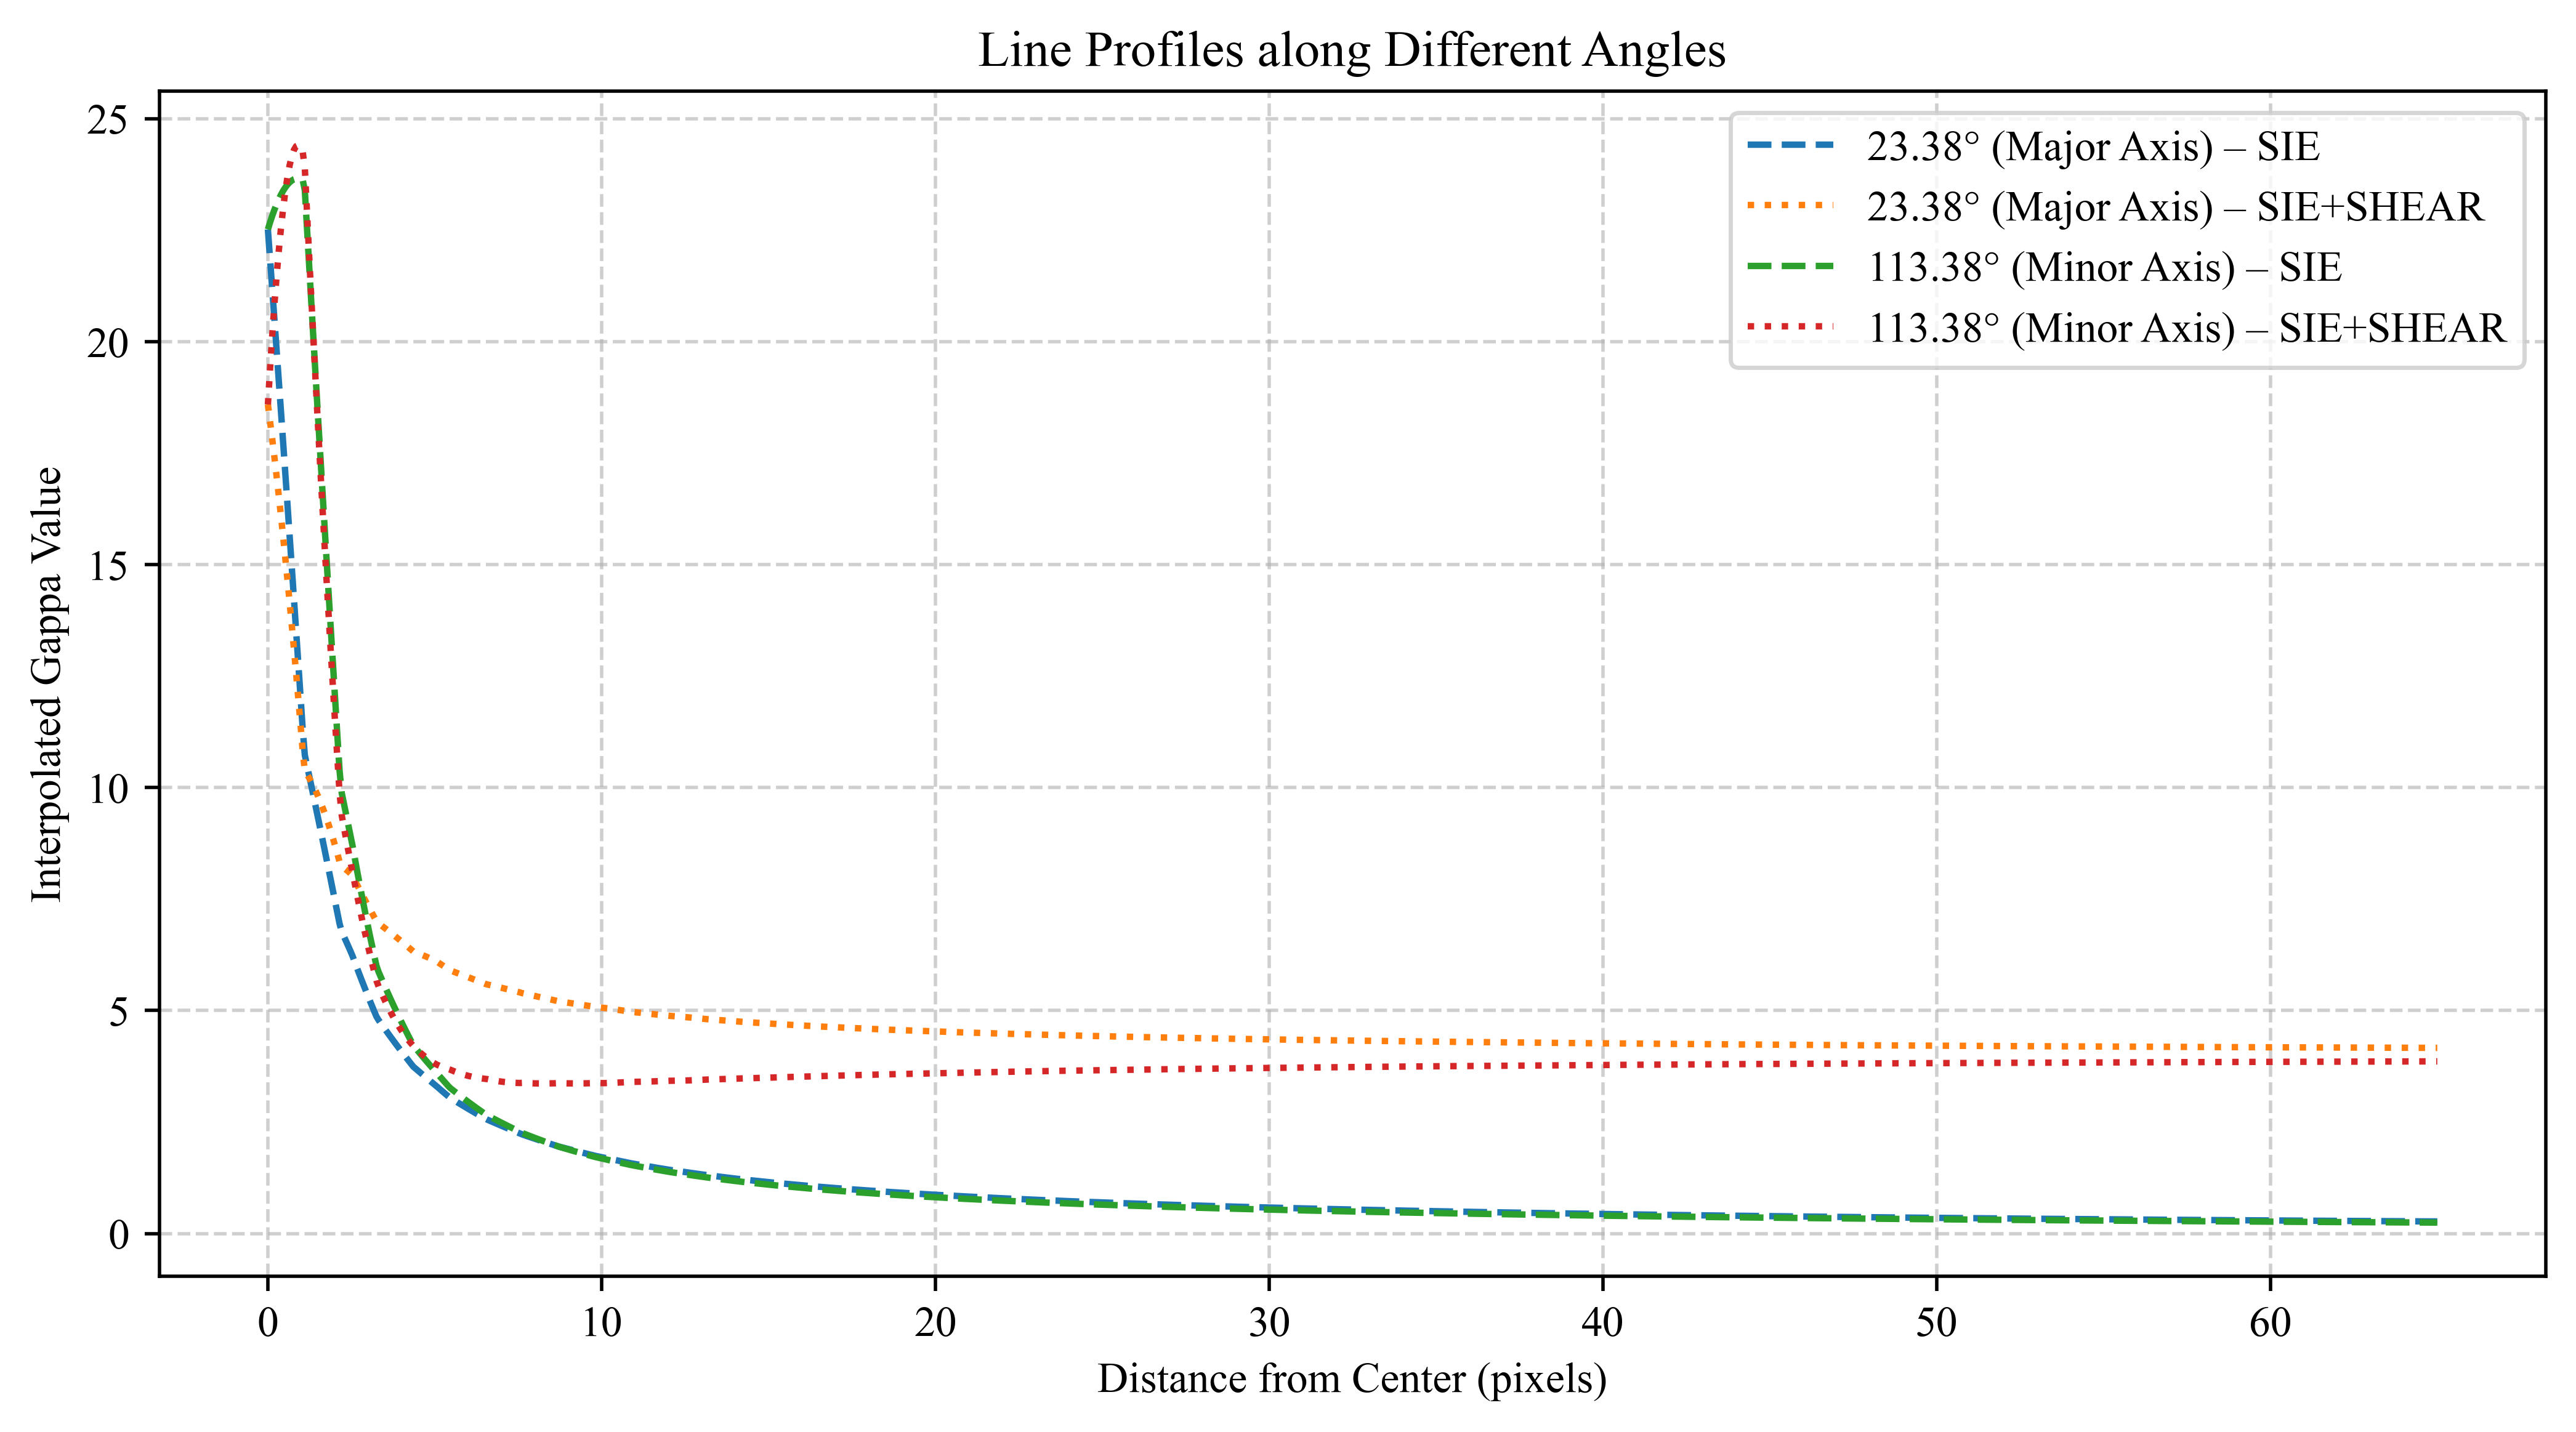

In [363]:
#======================================================================
# Method 2: Line Profile at a Specific Angle
#======================================================================
print("\n--- Calculating Line Profile at a Specific Angle ---")

major_axis = df['param5'][0]
minor_axis = df['param5'][0] + 90
x_crit = crit_curve[4].values
y_crit = crit_curve[5].values

angles_deg = [major_axis, minor_axis]
angle_names = ['Major Axis', 'Minor Axis']
max_radius = 65
num_points = 1000

center_x, center_y = centers
print(f"Center coordinates: ({center_x}, {center_y})")
center_x = (center_x - 20) / 0.01  # Convert to pixel coordinates
center_y = (center_y - 20) / 0.01  # Convert to pixel coordinates

# --- compute intersection radii with the critical curve ---
intersection_radii = []

angle_line = major_axis + 90             # same shift you use below
# vector from center to each critical-curve point
dx = x_crit - center_x
dy = y_crit - center_y

# compute each critical-curve point's angle (deg)
angles_curve = np.rad2deg(np.arctan2(dy, dx))

# find the index whose angle is closest to the profile line angle
diff = np.abs((angles_curve - angle_line + 180) % 360 - 180)
idx = np.argmin(diff)

# compute the intersection radius
r_int = np.hypot(dx[idx], dy[idx])
intersection_radii.append((major_axis, r_int))


plt.figure(figsize=(10, 5))

# plot each profile
for angle_deg_0 in angles_deg:
    angle_deg = angle_deg_0 + 90
    angle_rad = np.deg2rad(angle_deg)
    radii = np.linspace(0, max_radius, num=num_points)
    x_coords = center_x + radii * np.cos(angle_rad)
    y_coords = center_y + radii * np.sin(angle_rad)
    line_profile_sie = map_coordinates(gamma_sie, (y_coords, x_coords), order=1)
    line_profile_tot = map_coordinates(gamma_tot, (y_coords, x_coords), order=1)
    plt.plot(radii, line_profile_sie, '--',
             label=f'{angle_deg_0}° ({angle_names[angles_deg.index(angle_deg_0)]}) – SIE')
    plt.plot(radii, line_profile_tot, ':',
             label=f'{angle_deg_0}° ({angle_names[angles_deg.index(angle_deg_0)]}) – SIE+SHEAR')

# # then add the critical-curve intersections
# for angle_deg_0, r_int in intersection_radii:
#     plt.axvline(r_int, linestyle='-.', linewidth=1.5,
#                 label='Critical Curve Intersection')
#     plt.text(r_int, plt.ylim()[1]*0.9, 'Critical Curve', rotation=90,
#              va='top', ha='right', fontsize=8)

plt.title('Line Profiles along Different Angles')
plt.xlabel('Distance from Center (pixels)')
plt.ylabel('Interpolated Gappa Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()



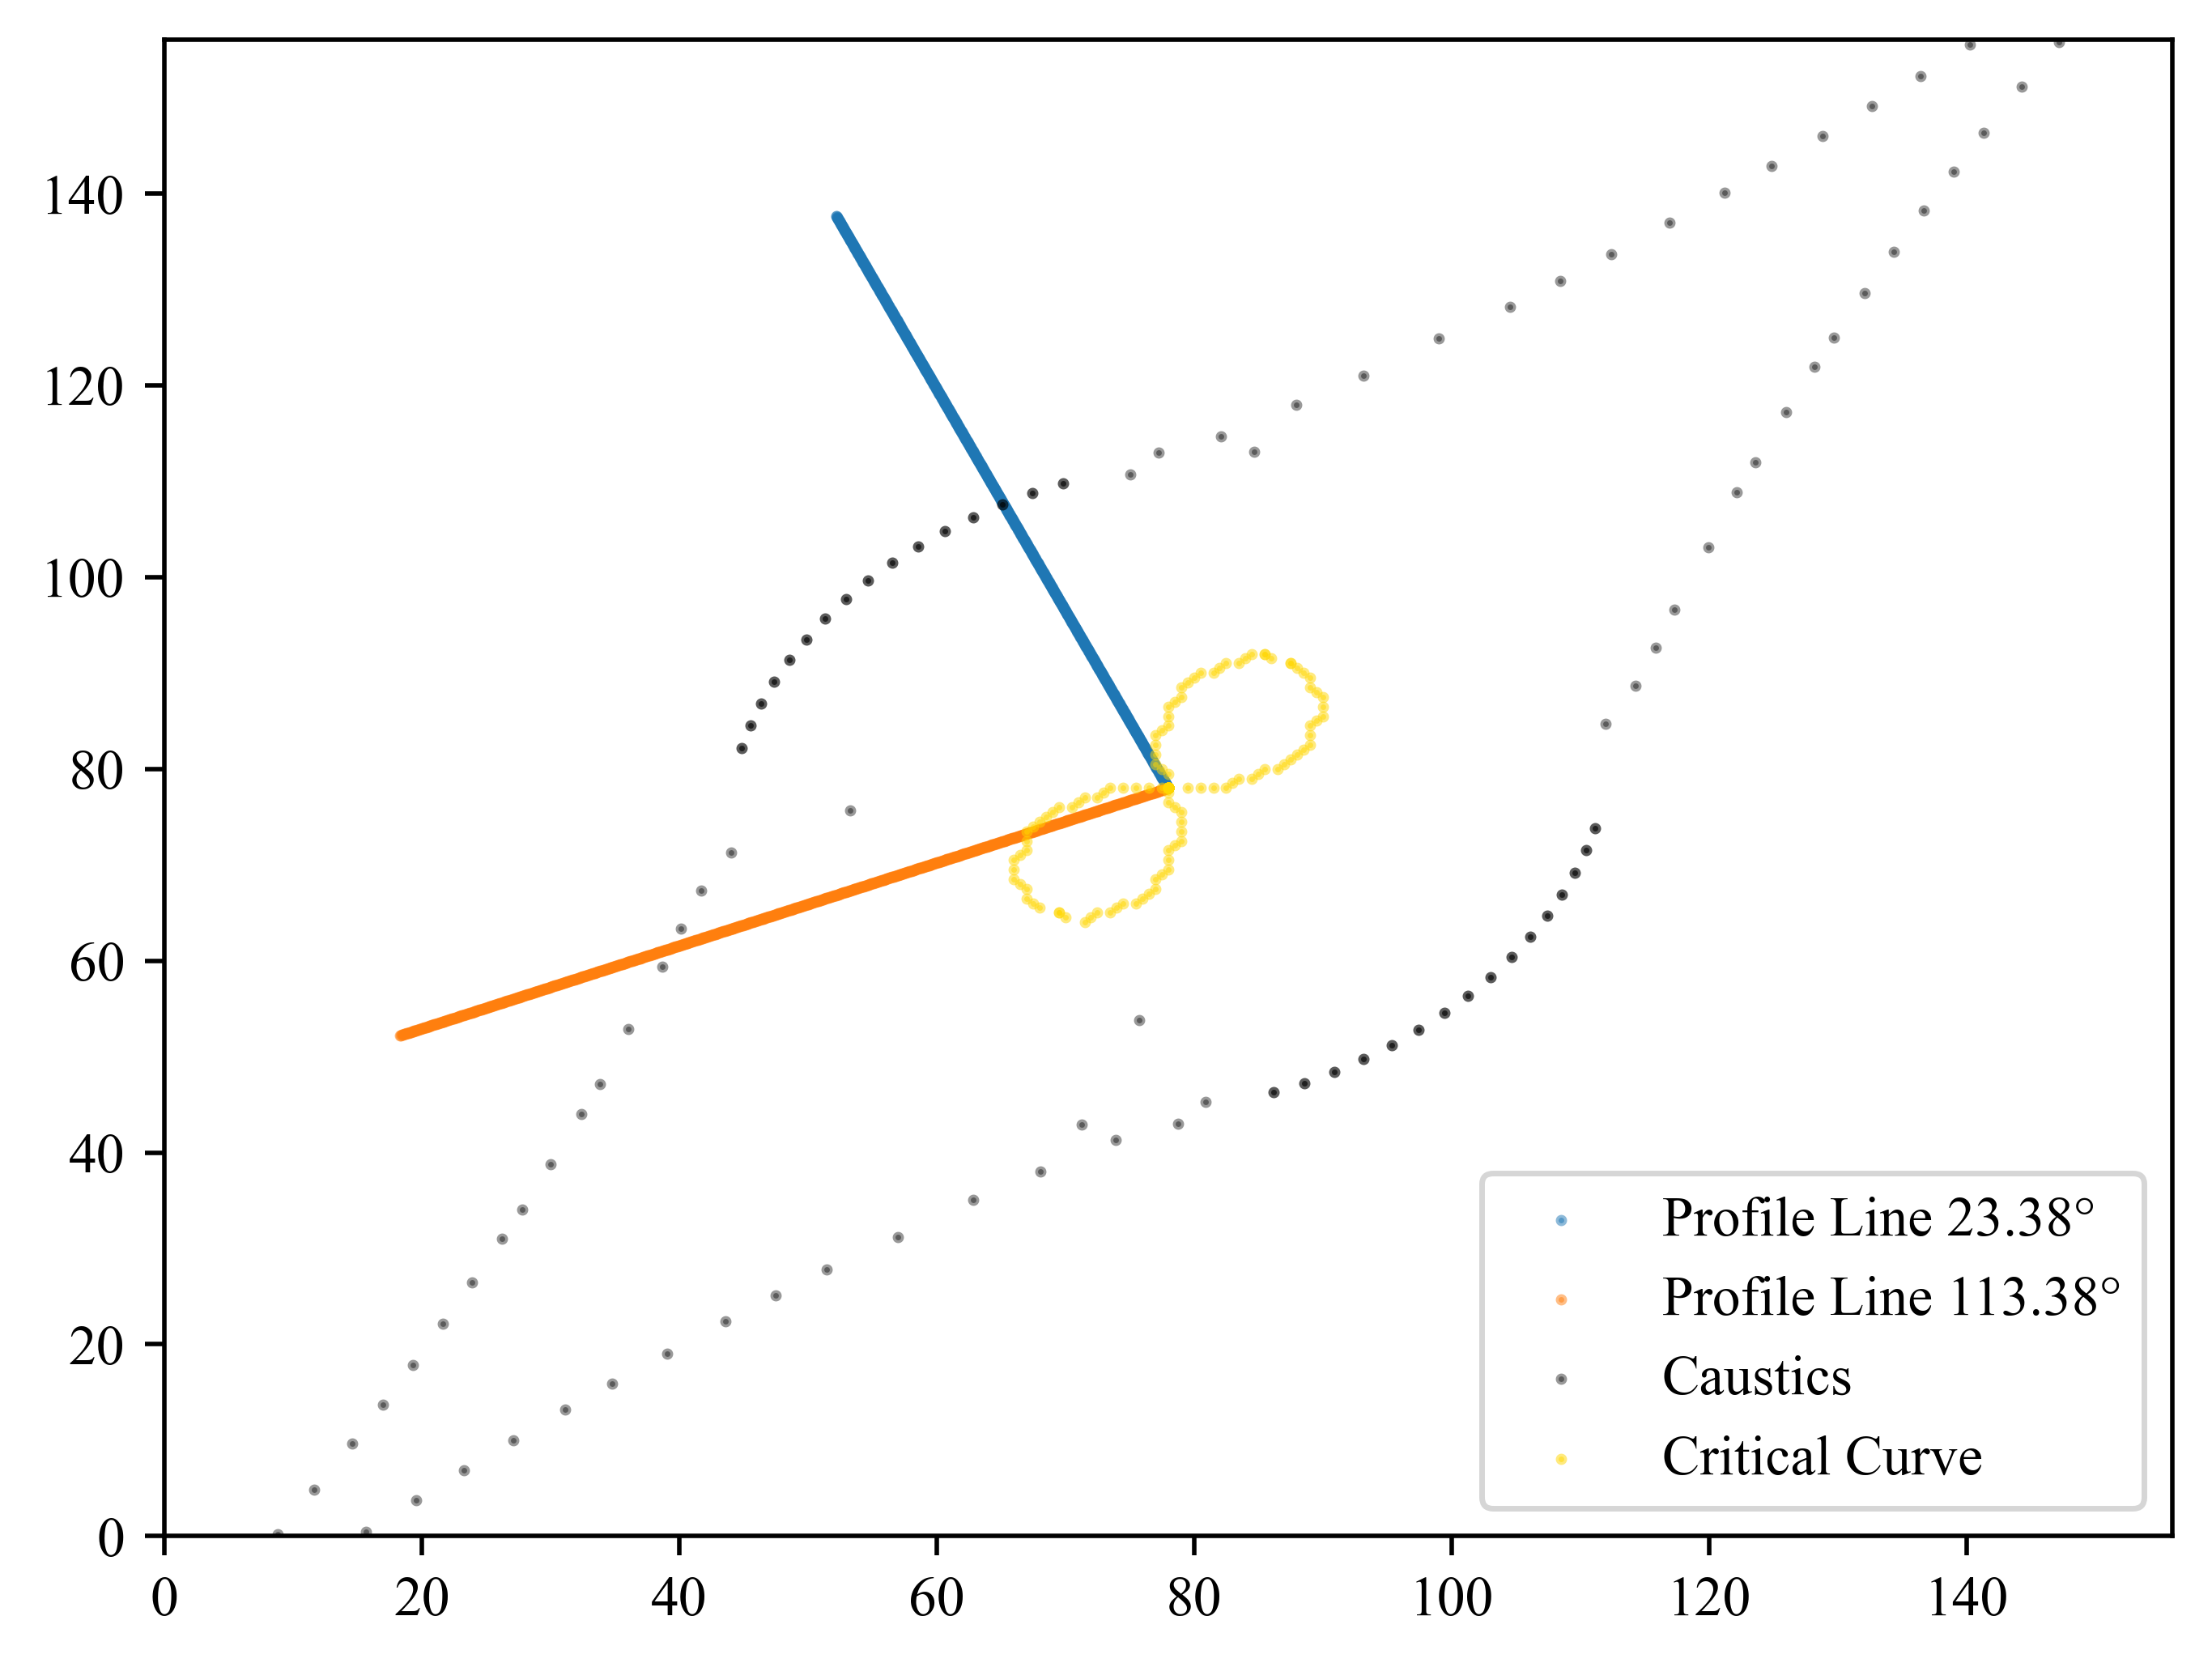

In [364]:
for angle_deg_0 in angles_deg:
    angle_deg = angle_deg_0 + 90
    angle_rad = np.deg2rad(angle_deg)
    radii = np.linspace(0, max_radius, num=num_points)
    x_coords = center_x + radii * np.cos(angle_rad)
    y_coords = center_y + radii * np.sin(angle_rad)
    plt.scatter(x_coords, y_coords, s=1, label='Profile Line' + f' {angle_deg_0}°', alpha=0.5)
plt.scatter(crit_curve[2], crit_curve[3], color='black', label='Caustics', s=1, alpha=0.4)
plt.scatter(crit_curve[4], crit_curve[5], color='gold', label='Critical Curve', s=1, alpha=0.5)
plt.xlim(0, 156)
plt.ylim(0, 156)
plt.legend()